In [3]:
import pandas as pd
import glob
from bs4 import BeautifulSoup
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import spacy
import nltk
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

# Analyse exploratoire - Catégorisez automatiquement des questions

## Mise en situation

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Les données

Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. Il nous faut écrire la requête SQL suivante:

## Contraintes
+ Mettre en œuvre une approche non supervisée.
+ Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
+ Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
+ Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
+ Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

# 1. Nettoyage et préparation des données
+ En premier lieu, le data set est chargé en utilisant les méthodes de la librairie Pandas, nous effectuons le cleaning initial des données, en supprimant les lignes ne contenant pas de tags (qui ne nous seront pas utiles), et les éventuels duplicata.
+ La taille initiale du Data Set est (50000, 4), taille maximale permise par requête unique sur Stack Exchange Data Explorer
+ Les données fournies qui nous seront utiles sont le titre de la question, le corps du texte et les tags associés.
+ Nous définissons ensuite l'ensemble des fonctions de nettoyage et de traitement du texte que nous utiliserons pour nettoyer chaque partie des données que nous allons utiliser

## 1.1. Chargement du Data Set

Puisqu'il a fallu télécharger les données de manière segmenter, il faut les importer en un seul dataset avant de travailler dessus :

In [5]:
raw_data_paths = glob.glob("Categorize_stackoverflow_questions/DATA/Sample1/*")

df = pd.DataFrame()

for path in raw_data_paths:
    if not df.empty:
        df = df.append(pd.read_csv(path, encoding='latin-1'), ignore_index=True)
    else:
        df = pd.read_csv(path, encoding='latin-1')

In [6]:
df.head()

,Title,Body,Tags
0,What is the purpose of anonymous { } blocks in...,<p>What is the purpose of anonymous { } blocks...,<c#><c++><c>
1,MEF: Unable to import in other classes?,"<p>Edit: Matt, that does indeed solves some (m...",<c#><wpf><null><mef>
2,How to zoom in/out an UIImage object when user...,<p>I would like to zoom in/out an UIImage obje...,<cocoa-touch><uiimage><uiimagejpegrepresentation>
3,What is the significance of starting constants...,<p>I'm teaching myself Objective-C and I notic...,<objective-c><constants>
4,How to split using a prefix character using re...,<p>I would like to split the example string:</...,<regex><split><character><prefix>


## 1.2. Nettoyage de la colonne 'Corpus'

Avant de travailler notre dataset, il s'agit de définir quelles données servent de target et celles qui servent de base au model (corpus).
+ Ici, il s'agit de prédir les Tags. La variable Tags est donc la target.
+ Les targets Title et Body correspondent donc à la base du model (au corpus). Puisque les deux variables sont des strings, les mergent n'affecte pas la prédiction et permet de réduire les étapes de traitement.

In [7]:
df['Corpus'] = df['Title'] + df['Body']

Et puisque les variables Title et Body n'ont plus de raisons d'êtres, on les retirent du dataset.

In [8]:
df.drop(['Title', 'Body'], axis=1, inplace=True)

Avant d'examiner le corpus, nous allons tout d'abord traiter le texte avec les opérations suivantes:

+ Retirer les balises HTML
+ Retirer les parties du message comportant du code
+ Retirer/Convertir les caractères qui ne sont pas des lettres
+ Convertir les lettres en minuscule

In [9]:
def remove_html(text):
    return BeautifulSoup(text, 'lxml').get_text()

In [10]:
def remove_code(text):
    pointer = text.find('<code>')
    while pointer !=-1:
        ender = text.find(u'</code>')
        text = text.replace(text[pointer: ender+7], ' ')
        pointer = text.find('<code>')
    return text

In [11]:
def remove_convert_non_letters(text):
    text = re.sub("c\+\+", "cplusplus", text)
    text = re.sub("c#", "csharp", text)
    text = re.sub("\.net", "dotnet", text)
    text = re.sub("d3\.js", "d3js", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.strip(u'\n')
    return text

In [12]:
def convert_to_lowercase_letters(text):
    return text.lower()

In [13]:
df['Corpus'] = df['Corpus'].apply(remove_code).apply(remove_html).apply(remove_convert_non_letters).apply(convert_to_lowercase_letters)

In [14]:
df.head()

,Tags,Corpus
0,<c#><c++><c>,what is the purpose of anonymous blocks in...
1,<c#><wpf><null><mef>,mef unable to import in other classes edit m...
2,<cocoa-touch><uiimage><uiimagejpegrepresentation>,how to zoom in out an uiimage object when user...
3,<objective-c><constants>,what is the significance of starting constants...
4,<regex><split><character><prefix>,how to split using a prefix character using re...


## 1.3. Nettoyage de la colonne 'Tags'

Cette variable (qui est la target de notre étude), doit se trouver sous la forme d'une liste de mots. Il faut donc :
+ Retirer les caractères qui ne sont pas liés au tag (typiquement les <>).
+ Retourner les mots sous forme de liste de mots.

In [15]:
def tag_clean(text):
    text = re.sub("<", "", text)
    text = re.sub(">", " ", text)
    text = text.split(" ")[:-1]
    return text

In [16]:
df['Tags'] = df['Tags'].apply(tag_clean)

L'objectif premier de cette étude est de proposer un taguage pour les utilisateurs novices à cette pratique. L'esprit de cette démarche est d'orienter l'utilisateur afin qu'il comprenne le fonctionnement du site. Il est donc inutile de proposer un taguage trop précis qui engendrera forcément des erreurs importantes.

Il va donc être limité le nombre de tags d'entrainement et de prédiction. Cette démarche va d'ailleurs réduire de manière notable le temps de process de cette étude (l'attribution d'un tag à un corpus est de plus en plus difficile plus les tags ont une fréquence d'occurence faible).

In [17]:
list_tags_raw = []
for Tags in df.Tags:
    list_tags_raw += Tags
df_Tags_occurence = pd.DataFrame(list_tags_raw, columns=["Tag"])
df_Tags_occurence = pd.DataFrame(df_Tags_occurence.Tag.value_counts())

Il est donc garder les 50 tags les plus fréquents.

In [21]:
most_frequent_tags = df_Tags_occurence.head(50)

Et on retire à présent tous les tags du dataset n'apparaissant pas dans cette liste des most_frequent_tags.

In [23]:
def tag_remover(list_tags):
    new_tags = [x for x in list_tags if x in most_frequent_tags.index]
    if new_tags:
        return new_tags
    else:
        return np.nan

In [24]:
df['Tags'] = df['Tags'].apply(tag_remover)

Aussi, on retire l'observation si la liste des tags est vide après avoir appliqué la condition du dessus.

In [25]:
print("Len of dataset before removing nan Tags observations: {}".format(len(df)))

Len of dataset before removing nan Tags observations: 93490


In [26]:
df.dropna(subset=["Tags"], inplace=True)

In [27]:
print("Len of dataset after removing nan Tags observations: {}".format(len(df)))

Len of dataset after removing nan Tags observations: 74892


Les Targets maintenant traitées, il est nécessaire de les mettrent en forme pour procéder à des entrainements de modèles. Il est ici utilisé la méthode MultiLabelBinarizer :

In [28]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['Tags'])
# save the model to disk
filename = 'Saves/multilabel_binarizer.pkl'
pickle.dump(multilabel_binarizer, open(filename, 'wb'))
 
# transform target variable
y = multilabel_binarizer.transform(df['Tags'])

for idx, tag in enumerate(multilabel_binarizer.classes_):
    df[tag] = y[:,idx]

In [29]:
df.head()

,Tags,Corpus,.net,ajax,algorithm,arrays,asp.net,asp.net-mvc,c,c#,c++,cocoa,cocoa-touch,css,database,debugging,delphi,django,eclipse,git,html,iphone,java,javascript,jquery,linq,linux,macos,multithreading,mysql,objective-c,performance,perl,php,python,regex,ruby,ruby-on-rails,security,sql,sql-server,string,svn,unit-testing,vb.net,visual-studio,visual-studio-2008,wcf,windows,winforms,wpf,xml
0,"[c#, c++, c]",what is the purpose of anonymous blocks in...,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[c#, wpf]",mef unable to import in other classes edit m...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,[cocoa-touch],how to zoom in out an uiimage object when user...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,[objective-c],what is the significance of starting constants...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[regex],how to split using a prefix character using re...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 2. Tokenisation

D'un point de vue du modèle de représentation par sac de mots (méthode que l'on va appliquer plus loin), des formes comme par exemple "drawing" et "drawings" sont si proches que les distinguer ne ferait qu'accroître le surapprentissage et ne permettrait pas au modèle d'exploiter pleinement les données d'apprentissage.

Ce problème peut être surmonté en représentant chaque mot à partir de sa racine afin de repérer les élements d'une même famille. Si cela est réalisé en utilisant une méthode heuristique, éliminant par exemple les préfixes et suffixes courants, on parle de stemming. Si on se sert d'un dictionnaire de formes connues et que le rôle du mot dans la phrase est pris en compte, le processus est appelé lemmatisation.

Pour se faire une idée de ces techniques, comparons ces méthodes avec la phrase suivante :

"Our meeting today was worse than yesturday, I'm scared of meeting the clients tomorrow."

In [ ]:
en_nlp = spacy.load('en_core_web_trf')
stemmer = nltk.stem.PorterStemmer()

In [ ]:
def compare_tokenisation(text):
    text_spacy = en_nlp(text)
    print("Lemmatization :")
    start = time.time()
    print([token.lemma_ for token in text_spacy])
    print("Temps de process de la lemmatisation : {} seconde\n".format(time.time()-start))
    print("Stemming :")
    start = time.time()
    print([stemmer.stem(token.norm_.lower()) for token in text_spacy])
    print("Temps de process du stemming : {} seconde".format(time.time()-start))

In [ ]:
compare_tokenisation("Our meeting today was worse than yesturday, I'm scared of meeting the clients tomorrow.")

Le stemming est toujours limité à l'ajustement du mot à sa racine, ce qui fait qu'ici was devient wa, alors que la lemmatisation trouve la forme verbale de base correcte, be. De même, la lemmatisation est capable de normaliser le mot worse en bad, alors que le stemming produit wors. Une autre différence majeure est que le stemming réduit les deux occurences de meeting et meet, alors que la lemmatisation reconnaît la première des deux comme étant un nom qu'elle conserve, et la seconde comme un verbe qui est réduit à sa forme meet.

Comme constaté, la lemmatisation est plus complexe que le stemming, mais elle produit aussi la plupart du temps de meilleurs résultats lorsqu'elle est utilisée pour normaliser des tokens.

Pour cette étude, on appliquera donc la méthode de la lemmatisation pour la tokenisation du dataset.

In [ ]:
en_nlp = spacy.load('en_core_web_trf')
def custom_tokenizer(text):
    text_spacy = en_nlp(text)
    tokens_lemma = [token.lemma_ for token in text_spacy]
    return ' '.join(tokens_lemma)

In [ ]:
df['Corpus'] = df['Corpus'].apply(custom_tokenizer)

# 3. Stopwords

Dans les languages courants (Anglais, Francais, ...), beaucoup de mots très courants sont sans intéret pour l'information aportée au modèle de ML. On peut donc supprimer ces mots pour alléger le modèle et possiblement le rendre plus juste dans sa prédiction.

Il existe deux méthodes :
+ Utiliser une liste de stopwords spécifiques à un language.
+ Eliminer les mots qui apparaissent trop fréquemment.

Pour notre étude, on va utiliser la première méthode. scikit-learn possède une liste de stopwords pour l'anglais dans le module feature_extraction.text:

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Nombre de stop words : {}".format(len(ENGLISH_STOP_WORDS)))
print("Exemple de stop words présents dans cette liste : {}".format(list(ENGLISH_STOP_WORDS)[::30]))

Très clairement, supprimer les stop words du vocabulaire ne peut que réduire le nombre de caractéristiques de la longueur de la liste, soit ici 318 mots de vocabulaire. Et cette technique peut conduire à une amélioration des performances de prédiction.

In [ ]:
def remove_stopwords(text):
    text_tokens = text.split()
    tokens_without_sw = [word for word in text_tokens if not word in ENGLISH_STOP_WORDS]
    tokens_without_sw = [word for word in tokens_without_sw if len(word) > 1 or word == 'c']
    tokens_without_sw = [word for word in tokens_without_sw if word.isspace()==False or word != "\n"]
    return ' '.join(tokens_without_sw)

In [ ]:
df['Corpus'] = df['Corpus'].apply(remove_stopwords)

# 4. Analyse du dataset

## 4.1. Analyse du corpus

In [254]:
# extract all words from Body's corpus
list_words_raw=[]
for word in df['Corpus']:
    list_words_raw += word.split()

In [255]:
df_Words = pd.DataFrame(list_words_raw, columns=["Word"])
df_Words = pd.DataFrame(df_Words.Word.value_counts())
df_Words.head(50)

,Word
use,75942
like,36611
code,32155
file,31567
way,29277
work,28161
c,26709
want,25898
need,21998
try,21969


In [256]:
common_words = ['use', 'like', 'file', 'code', 'way', 'work', 'want', 'need', 'try', 'application', 'know', 'just', 'make', 'user', 'create', 'run', 've', 'problem', 'look', 'good', 'example', 'don', 'thank', 'think', 'value', 'time', 'server', 'question', 'set', 'function', 'error', 'datum', 'type', 'write']
ENGLISH_STOP_WORDS = ENGLISH_STOP_WORDS.union(common_words)

In [257]:
df['Corpus'] = df['Corpus'].apply(remove_stopwords)

In [258]:
# extract all words from Body's corpus
list_words_raw=[]
for word in df['Corpus']:
    list_words_raw += word.split()
df_Words = pd.DataFrame(list_words_raw, columns=["Word"])
df_Words = pd.DataFrame(df_Words.Word.value_counts())

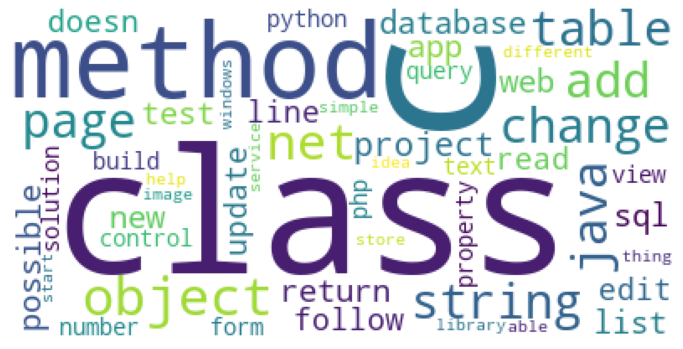

In [259]:
freq = df_Words.to_dict()['Word']
wordcloud = WordCloud(background_color='white', max_words=50)
wordcloud.generate_from_frequencies(freq)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 4.2. Analyse des targets

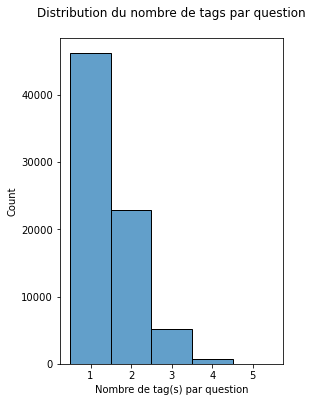

In [7]:
fig = plt.figure(figsize=(4, 6))
sns.histplot(data=df, x=df.Tags.str.len(), discrete=True, edgecolor="black", alpha=0.7)
plt.xlabel("Nombre de tag(s) par question")
plt.title(f"Distribution du nombre de tags par question\n")
plt.show()

Chaque question a entre 1 et 5 Tags. La distribution du nombre de tags par question s'approche d'une distribution normale avec le pic à 3 tags par questions.

A présent, observons l'occurence des 50 tags les plus fréquents sous forme de liste et de WordCloud:

In [261]:
# extract all tags
list_tags_raw=[]
for Tags in df.Tags:
    list_tags_raw += Tags

In [262]:
df_Tags = pd.DataFrame(list_tags_raw, columns=["Tag"])
df_Tags = pd.DataFrame(df_Tags.Tag.value_counts())
df_Tags.head(50)

,Tag
c#,13794
java,7986
.net,7272
c++,5282
python,4784
javascript,4529
php,4194
asp.net,3851
iphone,3045
jquery,3033


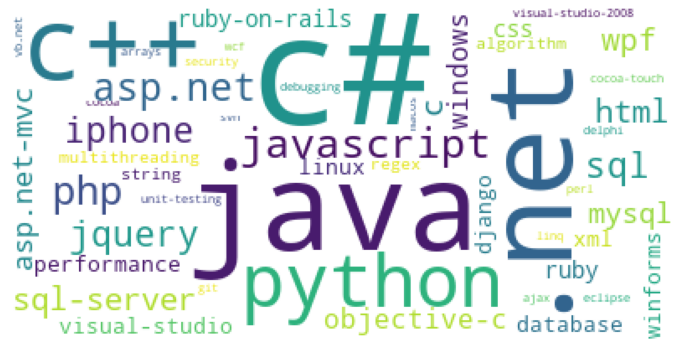

In [263]:
freq = df_Tags.to_dict()['Tag']
wordcloud = WordCloud(background_color='white', max_words=50)
wordcloud.generate_from_frequencies(freq)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 5. Export du dataset

In [1]:
path = 'Saves/Dataset_cleaned&shaped.pkl'

In [265]:
df.to_pickle(path)

In [5]:
df = pd.read_pickle(path)
#df = df.sample(n=10000, random_state=42)

In [8]:
df.head()

,Tags,Corpus,.net,ajax,algorithm,arrays,asp.net,asp.net-mvc,c,c#,c++,cocoa,cocoa-touch,css,database,debugging,delphi,django,eclipse,git,html,iphone,java,javascript,jquery,linq,linux,macos,multithreading,mysql,objective-c,performance,perl,php,python,regex,ruby,ruby-on-rails,security,sql,sql-server,string,svn,unit-testing,vb.net,visual-studio,visual-studio-2008,wcf,windows,winforms,wpf,xml
0,"[c#, c++, c]",purpose anonymous block c style language purpo...,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[c#, wpf]",mef unable import class edit matt solve linger...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,[cocoa-touch],zoom uiimage object pinch screen zoom uiimage ...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,[objective-c],significance start constant teach objective c ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[regex],split prefix character regular expression spli...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df.drop(['Tags', 'Corpus'], axis=1).head()

,.net,ajax,algorithm,arrays,asp.net,asp.net-mvc,c,c#,c++,cocoa,cocoa-touch,css,database,debugging,delphi,django,eclipse,git,html,iphone,java,javascript,jquery,linq,linux,macos,multithreading,mysql,objective-c,performance,perl,php,python,regex,ruby,ruby-on-rails,security,sql,sql-server,string,svn,unit-testing,vb.net,visual-studio,visual-studio-2008,wcf,windows,winforms,wpf,xml
0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 6. Représentation des données sous forme de sacs de mots (bag of words)

## 6.1. Création du Bag of Words

L'une des méthodes les plus simples, mais aussi les plus efficaces et les plus courantes, servant à transformer les textes afin de leur donner un format reconnaissable pour l'apprentissqge automatique, consiste à utiliser une représentation dites par sacs de mots (bag of words). Avec cette représentation, nous éliminons l'essentiel de la structure du texte présenté en entrée, comme les chapitres, les paragraphes, les phrases et tout ce qui concerne le formatage, et nous comptons uniquement le nombre d'apparitions de chaque mot dans chaque texte du corpus.

Calculer la représentation par sac de mots d'un corpus consiste à suivre une succession de trois étapes:
+ Tokenisation. Ce terme désigne le fait de partager un document dans les mots qui le composent, par exemple pour distinguer les espaces ou encore les signes de ponctuation. Un texte devient alors une séquence de tokens.
+ Construction du vocabulaire. Cela consiste à former un vocabulaire en collectant tous les mots qui apparaissent dans les documents afin de constituer un dictionnaire, et à les numéroter (par exemple dans l'ordre alphabétique).
+ Encodage. Pour chaque document, cette étape consiste à dénombrer le nombre d'occurence de chaque mot du vocabulaire.

Appliquons donc ces trois étapes sur notre jeu de données de stackoverflow.

In [33]:
print("df['Corpus'].shape : {}".format(df['Corpus'].shape))

df['Corpus'].shape : (74892,)


In [34]:
custom_vectorizer = CountVectorizer(tokenizer=None, stop_words=None, min_df=5) 

In [35]:
BOW = custom_vectorizer.fit_transform(df['Corpus'])

In [36]:
filename = 'custom_vectorizer.pkl'
pickle.dump(custom_vectorizer, open(filename, 'wb'))

In [272]:
BOW = BOW.toarray()
vocab = custom_vectorizer.get_feature_names()
BOW = pd.DataFrame(BOW, columns=vocab)

In [273]:
BOW.head()

,aa,ab,abandon,abc,ability,able,abort,absence,absolute,absolutely,abstract,abstraction,abuse,academic,accent,accept,acceptable,access,accessibility,accessible,accessor,accidentally,accommodate,accompany,accomplish,accord,accordingly,accordion,account,accross,accuracy,accurate,accurately,acheive,achieve,acquire,act,action,actionfilter,actionlink,actionresult,actionscript,activate,active,actively,activerecord,activex,activity,actual,actually,ad,adam,adapt,adapter,add,addendum,addin,addition,additional,additionally,addon,address,adjacent,adjust,admin,administration,administrator,admit,ado,adobe,adopt,advance,advanced,advantage,advice,advisable,advise,aes,afaik,affect,afford,aforementioned,afraid,age,agent,aggregate,aggregation,agile,agnostic,ago,agree,ahead,aim,air,ajax,aka,akin,al,ala,alas,...,windowsi,windsor,winform,winforms,winner,winxp,wipe,wire,wireshark,wisdom,wise,wish,wit,wix,wizard,wm,wmd,wmi,wo,won,wonder,wonderful,word,wordpress,workable,workaround,workbook,worker,workflow,worki,working,workingi,workspace,workstation,world,worried,worry,worth,worthwhile,wouldn,wp,wpf,wpfi,wrap,wrapper,writer,writing,wrong,ws,wsdl,wtf,www,wxpython,wysiwyg,xaml,xc,xcode,xcodei,xdocument,xelement,xhtml,xi,xib,xls,xml,xmldocument,xmlhttprequest,xmli,xmlserializer,xmpp,xna,xp,xpath,xps,xsd,xsl,xslt,xss,xx,xxx,xxxx,xy,xyz,yahoo,yaml,yeah,year,yellow,yes,yesterday,yield,youtube,yui,yyyy,zend,zero,zillion,zip,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 7. LDA  

Intuitivement, le modèle LDA essai de trouver des groupes de mots (sujets ou topics) qui apparaissent fréquemment ensemble. Il s’agit d’expliquer et de prédire l’appartenance d’un individu à une classe (groupe) prédéfinie à partir de ses caractéristiques mesurées à l’aide de variables prédictives.
Faisons un test pour mieux comprendre :

## 7.1. Test

In [274]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=42)
topics = lda.fit_transform(BOW)

In [275]:
def print_topics(topics, feature_names, sorting, topics_per_chunk=6, n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [276]:
sorting = np.argsort(lda.components_, axis=1)[:,::-1]
feature_names = np.array(BOW.columns)
print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
page          service       class         app           table         
html          web           object        python        sql           
javascript    client        method        java          database      
jquery        thread        test          windows       query         
element       message       property      program       column        
form          send          variable      memory        row           
browser       exception     instance      process       store         
css           log           return        iphone        mysql         
text          request       parameter     linux         key           
tag           connection    implement     start         model         


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
list

Sur le test ci-dessus, on cherche à prédire 10 classes/topics. Pour chacun de ces topics, on extrait les 10 mots du corpus les plus commun à ce topic. On distingue donc des sujets sur les topics tel que :
- topic 1: web
- topic 2: Programmation orientée objects
- topic 4: Data

La question est maintenant de savoir quel est le nombre de topics optimal permettant de  prédire au mieux un document ?

## 7.2. Recherche du nombre optimal de topics

La méthode GridSearchCV vue dans les précédent projets OpenClassrooms permettant de tester plusieurs parametres sur un modèle de prédiction va permettre dans ce cas de figure d'observer les résultats selon le nombre de topics prédits:

In [288]:
lda = LatentDirichletAllocation(learning_method="batch", max_iter=25, random_state=42)
n_components = [5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 50, 100, 200]
search_params = {'n_components': n_components}
model = GridSearchCV(lda, param_grid=search_params)
model.fit(BOW)

GridSearchCV(estimator=LatentDirichletAllocation(max_iter=25, random_state=42),
             param_grid={'n_components': [5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 50,
                                          100, 200]})

Text(0, 0.5, 'log likelihood')

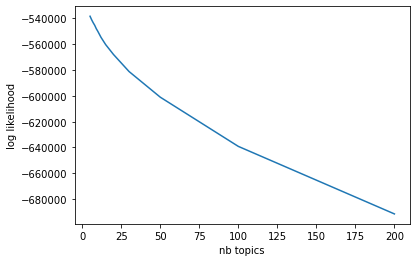

In [289]:
log_likelyhoods = model.cv_results_['mean_test_score']
plt.plot(n_components, log_likelyhoods)
plt.xlabel('nb topics')
plt.ylabel('log likelihood')

Il semblerait que le meilleur résultat soit obtenu lorsque le modèle prédit 5 topics.
Voyons la définition de ces topics:

In [290]:
lda_best = LatentDirichletAllocation(learning_method='online', n_jobs=-1, n_components=5)
topics_best = lda_best.fit_transform(BOW)

In [291]:
sorting = np.argsort(lda_best.components_, axis=1)[:,::-1]
feature_names = np.array(BOW.columns)
print_topics(topics=range(5), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
page          table         class         project       test          
view          sql           object        app           service       
control       database      method        build         php           
event         query         java          windows       client        
html          number        string        net           check         
image         array         property      version       exception     
javascript    memory        variable      library       web           
form          column        xml           java          message       
text          string        return        visual        send          
jquery        store         instance      source        thread        




Les sujets des topics prédits semblent êtres :
- topic 0: JS/web
- topic 1: Data
- topic 2: Programmation orientée objects
- topic 3: Android
- topic 4: Capture des mots les plus courants (qui pourraient être ajoutés aux stopwords)

Maintenant que le modèle est entrainé, il est possible de lui demander de classer un document selon les topics définies précédement:

In [292]:
print(df['Corpus'][92108])
print(df['Tags'][92108])
print(topics_best[0,:])

unit testing database test crud operation unit test database test crud operation sql lite help cre db memory mbunit
['unit-testing']
[0.01112713 0.21314535 0.01131028 0.01112428 0.75329297]


Ci-dessus, on a un document traitant d'un sujet lié au data. Quand on cherche à le classer dans les topics définis, il rend un résultat à 75% pour le topic numéro 4 (topic qui semble capturer les mots les plus courants). Ainsi, il est possible d'ignorer l'inertie du topic 4 puisqu'il est commun à toutes les prédictions. Le second topic capturant le plus d'inertie est le numéro 1, le topic lié à la data. On peut donc conclure que la prédiction du document ci-dessus est correcte si l'on retire l'inertie liée au topic capturant les mots courants.

In [317]:
filename = 'Saves/LDA.pkl'
pickle.dump(lda_best, open(filename, 'wb'))